In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Transform images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
batch_size = 64
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████| 9912422/9912422 [01:55<00:00, 85641.59it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 90932.34it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:11<00:00, 145925.87it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2256369.63it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

print("Training Complete!")


Epoch 1, Loss: 0.1683
Epoch 2, Loss: 0.0450
Epoch 3, Loss: 0.0300
Epoch 4, Loss: 0.0208
Epoch 5, Loss: 0.0177
Training Complete!


In [6]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


Accuracy: 99.12%


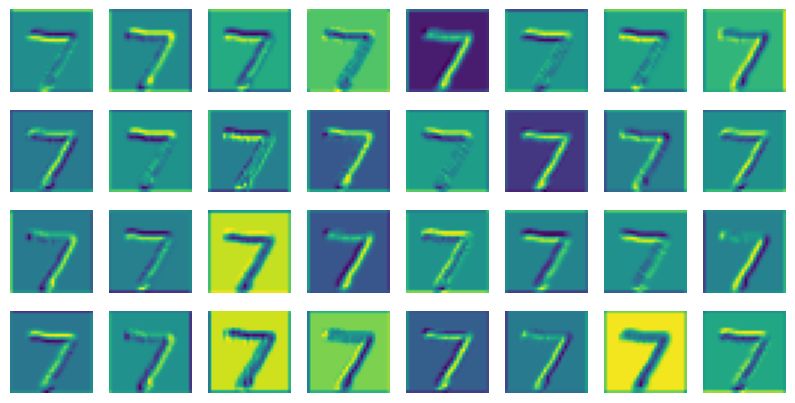

In [7]:
def visualize_feature_maps(model, image):
    image = image.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        activations = model.conv1(image)
    
    fig, axes = plt.subplots(4, 8, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        if i < activations.shape[1]:
            ax.imshow(activations[0, i].cpu().numpy(), cmap='viridis')
            ax.axis('off')
    plt.show()

# Get a sample image
sample_image, _ = next(iter(testloader))
sample_image = sample_image[0]
visualize_feature_maps(model, sample_image)


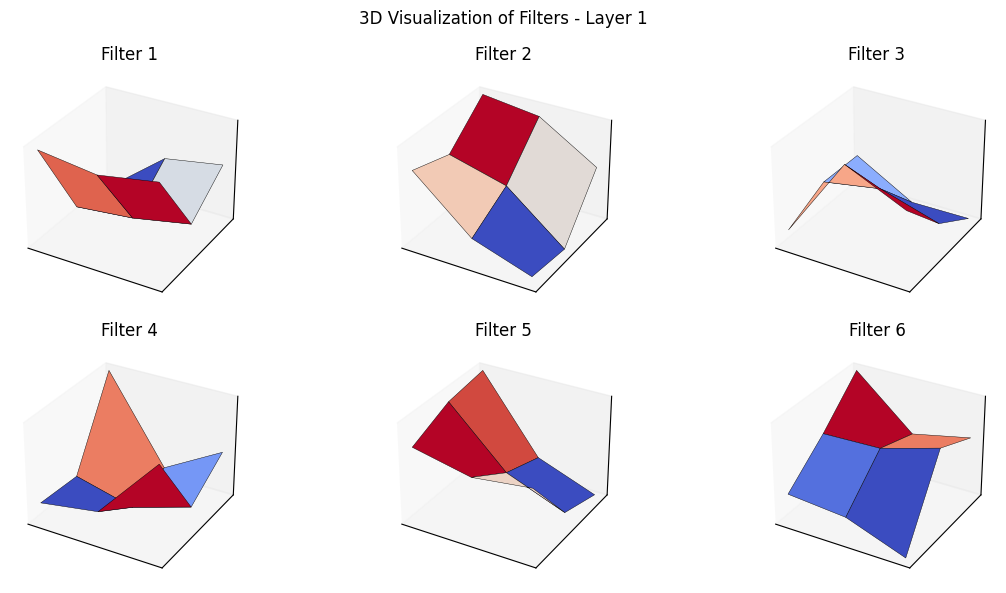

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to visualize filters in 3D
def plot_3d_filter(filters, layer_num):
    filters = filters.cpu().numpy()  # Convert to NumPy
    num_filters = min(6, filters.shape[0])  # Limit to 6 filters for clarity
    
    fig = plt.figure(figsize=(12, 6))
    
    for i in range(num_filters):
        ax = fig.add_subplot(2, 3, i+1, projection='3d')
        x, y = np.meshgrid(range(filters.shape[2]), range(filters.shape[3]))  # Grid for plotting
        ax.plot_surface(x, y, filters[i, 0], cmap='coolwarm', edgecolor='k', linewidth=0.3)
        ax.set_title(f'Filter {i+1}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    plt.suptitle(f'3D Visualization of Filters - Layer {layer_num}')
    plt.tight_layout()
    plt.show()

# Extract filters from the first convolutional layer
filters = model.conv1.weight.data
plot_3d_filter(filters, layer_num=1)
